# Install Dependencies

In [ ]:
!pip install -q transformers transformers[sentencepiece] datasets

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi

Mon Nov  8 16:37:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data Preparation

## Load Dataset and Tokenized Text

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("amazon_reviews_multi", "en")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["review_title"], example["review_body"],max_length=512,truncation=True)

def change_labels(example):
    example['stars'] -=1
    return example
raw_datasets = raw_datasets.map(change_labels)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Downloading:   0%|          | 0.00/2.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/82.0M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.06M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/2.05M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset amazon_reviews_multi downloaded and prepared to /root/.cache/huggingface/datasets/amazon_reviews_multi/en/1.0.0/724e94f4b0c6c405ce7e476a6c5ef4f87db30799ad49f765094cf9770e0f7609. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

  0%|          | 0/200000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/200 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets=tokenized_datasets.remove_columns(['language', 'product_category', 'product_id', 'review_body', 'review_id', 'review_title','reviewer_id'])
tokenized_datasets=tokenized_datasets.rename_column('stars','labels')

# Training

## Set Training Argument

In [ ]:
from transformers import TrainingArguments
import numpy as np
from datasets import load_metric
from sklearn.metrics import precision_recall_fscore_support,accuracy_score


training_args=TrainingArguments(
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    save_steps=3000,
    overwrite_output_dir=True,
    output_dir='gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr',
    load_best_model_at_end =True,
    evaluation_strategy ='steps',
    eval_steps = 1500,
    metric_for_best_model ='eval_loss',
    greater_is_better=False,
    # dataloader_num_workers=0
    remove_unused_columns=True
    
)

In [ ]:
from transformers import AutoModelForSequenceClassification,EarlyStoppingCallback,AdamW,get_cosine_schedule_with_warmup
from transformers.optimization import Adafactor, AdafactorSchedule
from transformers import Trainer

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5,ignore_mismatched_sizes=True)

optimizer = AdamW(model.parameters(), 
                  lr = training_args.learning_rate, 
                  weight_decay=training_args.weight_decay)

lr_scheduler = get_cosine_schedule_with_warmup(optimizer,
                                               num_warmup_steps=training_args.warmup_steps,
                                               num_training_steps=round(len(tokenized_datasets['train'])/training_args.per_device_train_batch_size)* training_args.num_train_epochs )

# optimizer = Adafactor(model.parameters(),
#                       relative_step=True, 
#                       warmup_init=True, 
#                       lr=None,
#                       scale_parameter =True,
#                       weight_decay=training_args.weight_decay)

# lr_scheduler = AdafactorSchedule(optimizer,initial_lr=training_args.learning_rate)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience = 4)],
    optimizers=(optimizer,lr_scheduler)
    # compute_metrics=compute_metrics
)


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Training

In [ ]:
trainer.train(resume_from_checkpoint=True)

Loading model from gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-3000).
***** Running training *****
  Num examples = 200000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 25000
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 3000
  Will skip the first 0 epochs then the first 3000 batches in the first epoch. If this takes a lot of time, you can add the `--ignore_data_skip` flag to your launch command, but you will resume the training on data already seen by your model.


  0%|          | 0/3000 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss
4500,0.812600,0.813288
6000,0.809800,0.807331
7500,0.790500,0.800317
9000,0.785900,0.805375
10500,0.791600,0.791465
12000,0.783900,0.794957
13500,0.711300,0.805014
15000,0.689300,0.810279
16500,0.707800,0.802851
18000,0.704800,0.795850


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
Saving model checkpoint to gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-6000
Configuration saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-6000/config.json
Model weights saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-6000/pytorch_model.bin
tokenizer config file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-6000/tokenizer_config.json
Special tokens file saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score_cosine_lr/checkpoint-6000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16
Saving model

KeyboardInterrupt: ignored

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 5000
  Batch size = 16


Step,Training Loss,Validation Loss
4500,0.812600,0.813288
6000,0.809800,0.807331
7500,0.790500,0.800317
9000,0.785900,0.805375
10500,0.791600,0.791465
12000,0.783900,0.794957
13500,0.711300,0.805014
15000,0.689300,0.810279
16500,0.707800,0.802851
18000,0.704800,0.795850


{'eval_loss': 0.7960813641548157}

In [ ]:
trainer.save_model("gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score/distilbert_aws_review_score_cosine_lr")

Saving model checkpoint to gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score/distilbert_aws_review_score_cosine_lr
Configuration saved in gdrive/MyDrive/nvidia/huggingface/AWS_REVIEW/distilbert_aws_review_score/distilbert_aws_review_score_cosine_lr/config.json


# Predict

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(
    "fill-mask",
    model="airesearch/wangchanberta-base-att-spm-uncased",
    tokenizer="airesearch/wangchanberta-base-att-spm-uncased",
    
)


loading configuration file https://huggingface.co/airesearch/wangchanberta-base-att-spm-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/616a9e2dfc52e9d019b75d219ed800a27158ed299bd4fad91363110fe93dfce1.27c4f6581fbedf3d12e9fae96d4fbb8bc3064cd88ae545414e7cffc7c5bbc52f
Model config CamembertConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "camembert",
  "num_attention_head": 12,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.3",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 25

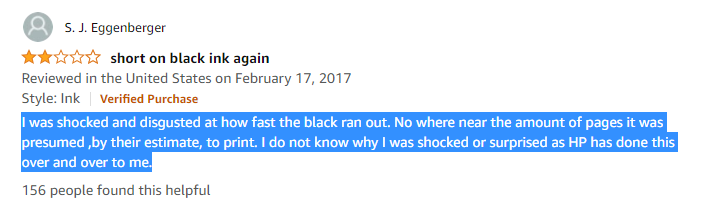

In [ ]:
sentiment_model('short on black ink again I was shocked and disgusted at how fast the black ran out. No where near the amount of pages it was presumed ,by their estimate, to print. I do not know why I was shocked or surprised as HP has done this over and over to me.')

[{'label': '2', 'score': 0.5104056000709534}]

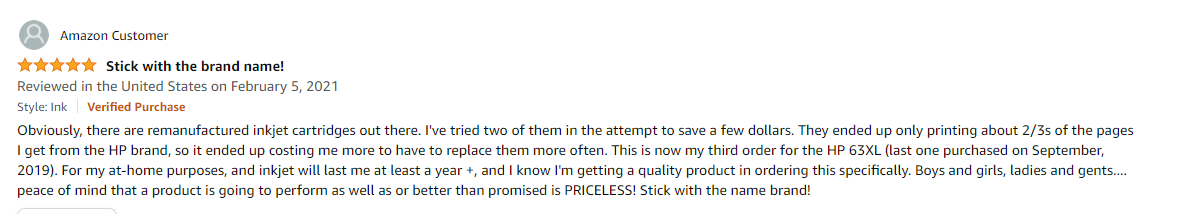

In [ ]:
sentiment_model('''5.0 out of 5 stars Stick with the brand name! Obviously, there are remanufactured inkjet cartridges out there. I've tried two of them in the attempt to save a few dollars. They ended up only printing about 2/3s of the pages I get from the HP brand, so it ended up costing me more to have to replace them more often. This is now my third order for the HP 63XL (last one purchased on September, 2019). For my at-home purposes, and inkjet will last me at least a year +, and I know I'm getting a quality product in ordering this specifically. Boys and girls, ladies and gents.... peace of mind that a product is going to perform as well as or better than promised is PRICELESS! Stick with the name brand!''')

[{'label': '5', 'score': 0.6570360660552979}]

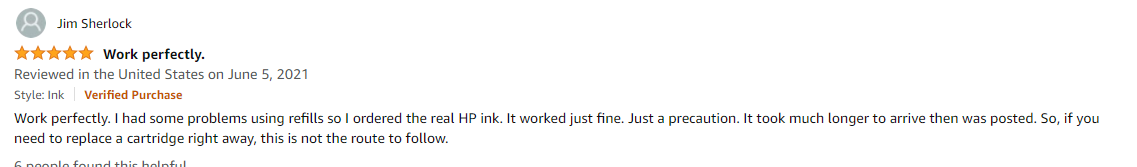

In [ ]:
sentiment_model('Work perfectly. Work perfectly. I had some problems using refills so I ordered the real HP ink. It worked just fine. Just a precaution. It took much longer to arrive then was posted. So, if you need to replace a cartridge right away, this is not the route to follow.')

[{'label': '5', 'score': 0.5300765633583069}]

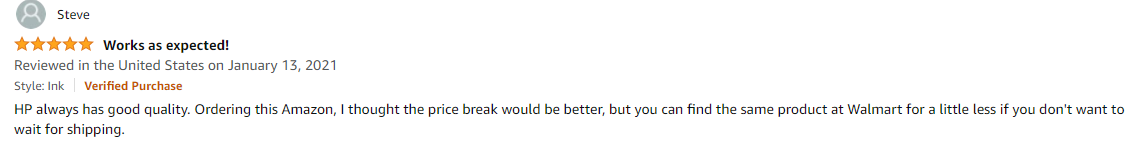

In [ ]:
sentiment_model(''' Works as expected! HP always has good quality. Ordering this Amazon, I thought the price break would be better, but you can find the same product at Walmart for a little less if you don't want to wait for shipping.''')

[{'label': '5', 'score': 0.8727130889892578}]

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 5000
  Batch size = 8


(5000, 5) (5000,)


In [ ]:
y_pred=np.argmax(predictions.predictions,axis=-1)
print(y_pred)

y_true=np.array(tokenized_datasets["test"]['labels'])
print(y_true)

[0 0 0 ... 4 4 4]
[0 0 0 ... 4 4 4]


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['0','1','2','3','4']))


              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1000
           1       0.56      0.61      0.58      1000
           2       0.58      0.56      0.57      1000
           3       0.63      0.61      0.62      1000
           4       0.79      0.79      0.79      1000

    accuracy                           0.66      5000
   macro avg       0.66      0.66      0.66      5000
weighted avg       0.66      0.66      0.66      5000



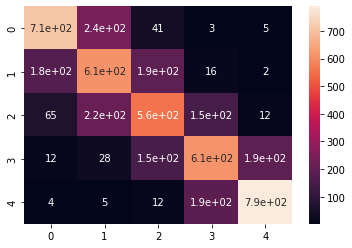

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)